In [32]:
import pandas as pd
import numpy as np 
from numpy import random
import nltk, re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Dropout, Bidirectional

from sentence_transformers import SentenceTransformer

In [24]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [17]:
df = pd.read_csv('stock_data.csv')

In [18]:
df.head()

Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2  user I'd be afraid to short AMZN - they are lo...          1
3                                  MNTA Over 12.00            1
4                                   OI  Over 21.37            1

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

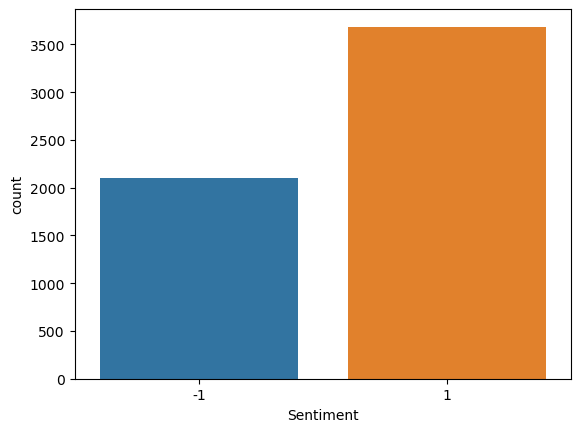

In [20]:
sns.countplot(x ='Sentiment', data = df)

In [21]:
ix = list(range(df.shape[0]))
ix = random.permutation(ix)

In [27]:
%%time
div = int(df.shape[0] * 0.7)
train_df = df.iloc[ix[0:div]]
corpus_train = train_df[['Text']]

test_df = df.iloc[ix[div:]]
corpus_test = test_df[['Text']]

CPU times: user 8.49 ms, sys: 168 µs, total: 8.66 ms
Wall time: 7.45 ms


In [29]:
%%time
corpus_train_enc = sbert_model.encode(corpus_train['Text'].values)

CPU times: user 8min 34s, sys: 3.63 s, total: 8min 38s
Wall time: 4min 21s


In [30]:
corpus_train_enc.shape

(4053, 768)

In [33]:
maxlen = 768
X_train_padded = keras.preprocessing.sequence.pad_sequences(corpus_train_enc, maxlen=maxlen, padding='post')
#X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

In [78]:
vocabulary_size = 768 
embedding_size = round(vocabulary_size / 10)
# 1: 2022-09-20 16:18:08.401718: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 603979776 exceeds 10% of free system memory.
# 2: 2022-09-20 16:17:35.349071: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 301989888 exceeds 10% of free system memory.
# 3: 2022-09-20 16:18:34.816216: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 201326592 exceeds 10% of free system memory.

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, trainable=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 77)          59136     
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              72704     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 132,098
Trainable params: 132,098
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(np.array(train_df['Sentiment']).reshape(-1, 1))

In [88]:
print(X_train_padded.shape)
print(y_train_encoded.shape)

(4053, 768)
(4053, 2)


In [89]:
model.fit(X_train_padded, y_train_encoded, batch_size=256, epochs=5)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_10/embedding_9/embedding_lookup' defined at (most recent call last):
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_21613/3007124033.py", line 1, in <cell line: 1>
      model.fit(X_train_padded, y_train_encoded, batch_size=256, epochs=5)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ashish/anaconda3/envs/stock_market_prediction/lib/python3.10/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_10/embedding_9/embedding_lookup'
indices[240,44] = -1 is not in [0, 768)
	 [[{{node sequential_10/embedding_9/embedding_lookup}}]] [Op:__inference_train_function_47997]